In [1]:
using BSON
using BSON: @save, @load
using Flux
using Plots

In [2]:
include("src/NN_Retrainer.jl")

Main.NN_Retrainer

In [3]:
@timev NN_Retrainer.main(16.0, 2000000, 0.0001, 2000000//10)

///////////////////////////////////////////////////////////////////////////////
                                Retrainer
///////////////////////////////////////////////////////////////////////////////
    
Neural Network would be changed from:
File: model-iter-101.bson
Activations: ["identity", "relu", "relu", "identity"]
Structure: [8, 30, 30, 30, 1]
Bias: false
Float64: true
To:
Saved to file: output_model.bson
Activations: ["identity", "relu", "identity"]
Structure: [8, 10, 8, 1]
Bias: false
Float64: true
Iteration 2000000: loss = 7.1304236943868644 52.822849 seconds (585.67 M allocations: 43.479 GiB, 3.59% gc time, 11.13% compilation time: 7% of which was recompilation)
elapsed time (ns):  52822849375
gc time (ns):       1897205443
bytes allocated:    46684865280
pool allocs:        585659940
non-pool GC allocs: 13181
malloc() calls:     11
realloc() calls:    5
free() calls:       8
minor collections:  1011
full collections:   2


In [4]:
model = nothing
BSON.@load "model-iter-101.bson" model

In [5]:
model

Chain(
  Dense(8 => 30; bias=false),           # 240 parameters
  Dense(30 => 30, relu; bias=false),    # 900 parameters
  Dense(30 => 30, relu; bias=false),    # 900 parameters
  Dense(30 => 1; bias=false),           # 30 parameters
)                   # Total: 4 arrays, 2_070 parameters, 16.516 KiB.

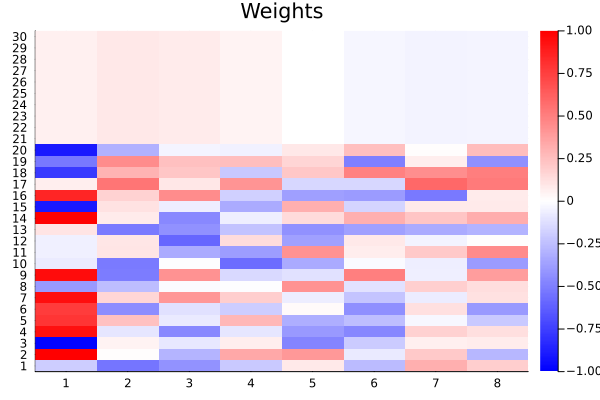

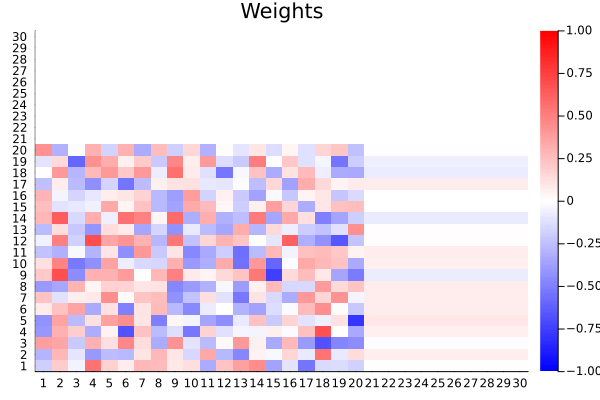

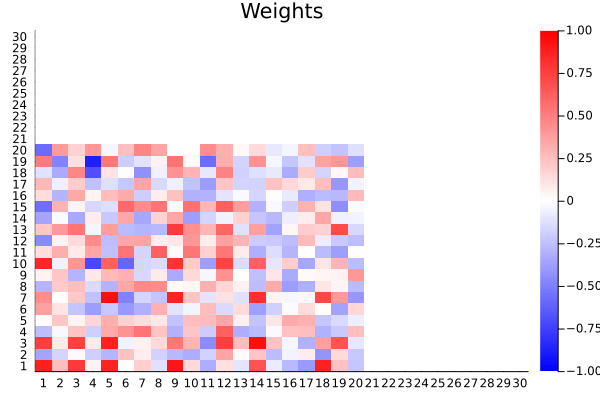

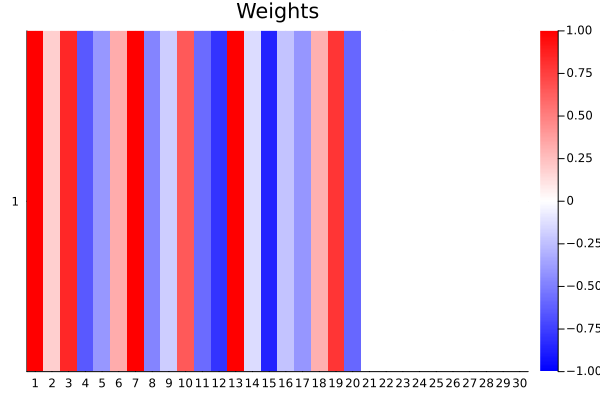

In [6]:
NN_Retrainer.plot_model_parameters(model)

In [7]:
model = nothing
BSON.@load "output_model.bson" model


In [8]:
model

Chain(
  Dense(8 => 10; bias=false),           # 80 parameters
  Dense(10 => 8, relu; bias=false),     # 80 parameters
  Dense(8 => 1; bias=false),            # 8 parameters
)                   # Total: 3 arrays, 168 parameters, 1.570 KiB.

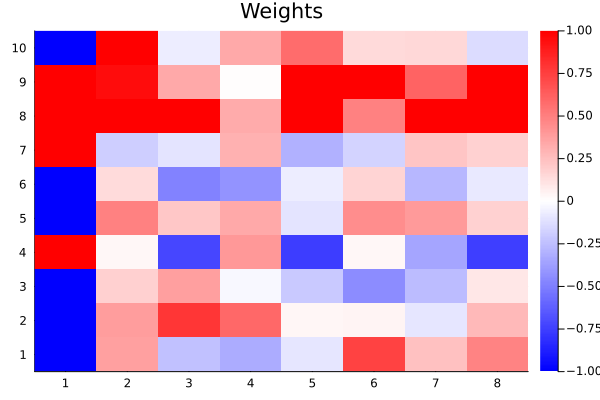

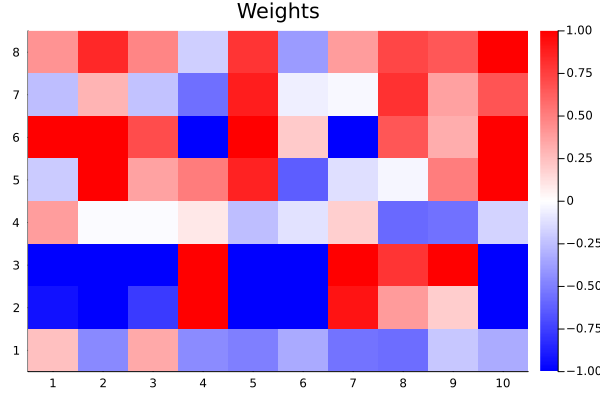

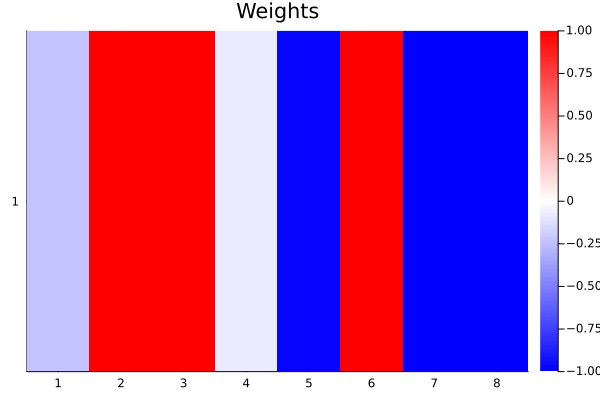

In [9]:
NN_Retrainer.plot_model_parameters(model)

# Testing

In [10]:
model = nothing
output_model = nothing

BSON.@load "output_model.bson" model
output_model = model
model = nothing
BSON.@load "model-iter-101.bson" model



mul = 1
n1 = size(model.layers[1].weight)[2]
n2 = size(output_model.layers[1].weight)[2]

failed_test_counter = 0
num_iters = 1000
for i in 1:num_iters
    input_vector1 = rand(n1) .* mul
    v_2 = rand(n2 - n1) .* mul
    input_vector2 = vcat(input_vector1, v_2)
    result1 = model(input_vector1)
    result2 = output_model(input_vector2)
    if abs(result1[1] - result2[1]) > 0.1
        # println("❌ Failed test!")
        # println("Input model result: $(result1[1])")
        # println("Output model result: $(result2[1])")
        # println("Difference: $(abs(result1[1] - result2[1]))")
        failed_test_counter += 1
    end
    mul *= -1
end

println("Percent of failed tests: $(failed_test_counter/num_iters)")


Percent of failed tests: 0.875


In [11]:
# One test
input_vector1 = rand(n1) .* mul
result1 = model(input_vector1)
result2 = output_model(input_vector1)
println("Input model result: $(result1[1])")
println("Output model result: $(result2[1])")

Input model result: 22.027526408290075
Output model result: 21.6663915853825


In [12]:
model

Chain(
  Dense(8 => 30; bias=false),           # 240 parameters
  Dense(30 => 30, relu; bias=false),    # 900 parameters
  Dense(30 => 30, relu; bias=false),    # 900 parameters
  Dense(30 => 1; bias=false),           # 30 parameters
)                   # Total: 4 arrays, 2_070 parameters, 16.516 KiB.

In [13]:
output_model

Chain(
  Dense(8 => 10; bias=false),           # 80 parameters
  Dense(10 => 8, relu; bias=false),     # 80 parameters
  Dense(8 => 1; bias=false),            # 8 parameters
)                   # Total: 3 arrays, 168 parameters, 1.570 KiB.

# Fine tuning

In [14]:
output_model = NN_Retrainer.fine_tune_training!(output_model, 16.0, 2000000, 0.00001, 100000)

Iteration 100000: loss = 1.0893715878533365
Iteration 200000: loss = 2.277247374544786
Iteration 300000: loss = 0.0936596821349007
Iteration 400000: loss = 17.06161414471237
Iteration 500000: loss = 12.690470948637511
Iteration 600000: loss = 213.04894376253824
Iteration 700000: loss = 27.661672427386293
Iteration 800000: loss = 0.7333451726719229
Iteration 900000: loss = 4.350089906807281
Iteration 1000000: loss = 1.0666293058307794
Iteration 1100000: loss = 0.56834835743485
Iteration 1200000: loss = 25.323304000830948
Iteration 1300000: loss = 638.5271610162023
Iteration 1400000: loss = 31.48606981879385
Iteration 1500000: loss = 2.885380244627675
Iteration 1600000: loss = 125.23309399509814
Iteration 1700000: loss = 15.862169719027337
Iteration 1800000: loss = 0.1075500592285518
Iteration 1900000: loss = 298.2643139789015
Iteration 2000000: loss = 9.306339733753006


Chain(
  Dense(8 => 10; bias=false),           # 80 parameters
  Dense(10 => 8, relu; bias=false),     # 80 parameters
  Dense(8 => 1; bias=false),            # 8 parameters
)                   # Total: 3 arrays, 168 parameters, 1.570 KiB.

In [15]:
output_model

Chain(
  Dense(8 => 10; bias=false),           # 80 parameters
  Dense(10 => 8, relu; bias=false),     # 80 parameters
  Dense(8 => 1; bias=false),            # 8 parameters
)                   # Total: 3 arrays, 168 parameters, 1.570 KiB.

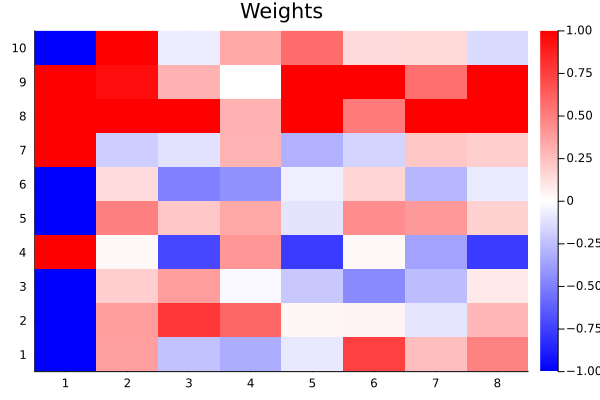

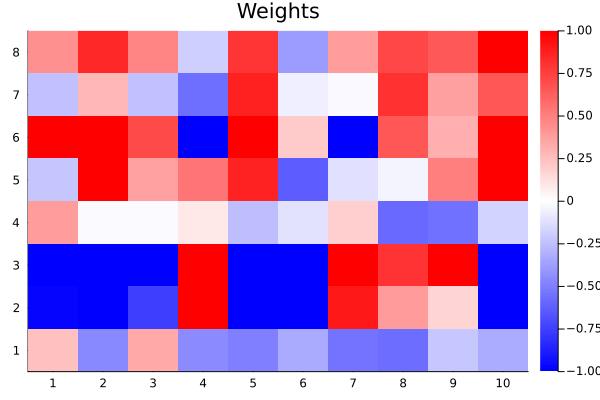

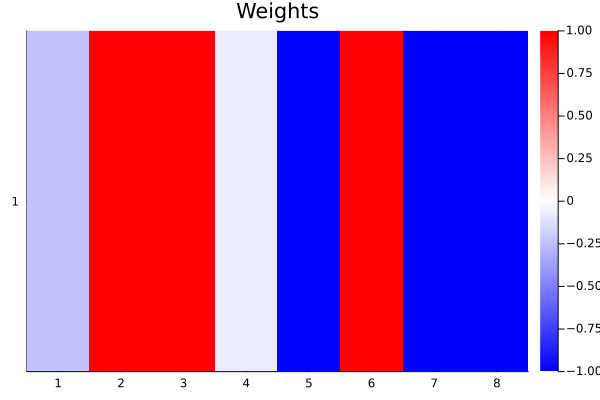

In [16]:
NN_Retrainer.plot_model_parameters(output_model)

In [17]:
model = nothing
BSON.@load "model-iter-101.bson" model

mul = 16
n1 = size(model.layers[1].weight)[2]

failed_test_counter = 0
num_iters = 1000
for i in 1:num_iters
    input_vector1 = rand(n1) .* mul
    result1 = model(input_vector1)
    result2 = output_model(input_vector1)
    if abs(result1[1] - result2[1]) > 0.1
        failed_test_counter += 1
    end
    mul *= -1
end

println("Percent of failed tests: $(failed_test_counter/num_iters)")


Percent of failed tests: 0.986
